# Research note
step 1: quantify the edge
This notebook tries to do the following things:
- show the metallicity effect of the edge location
- quantify the edge using a spline interpolation or boundary fit?
- compare the distributions of the distances from each point to the edges

somthing to note
- what does the sharpness of the edge tells about the precison of the scaling relations?
perturb the scaling relations to see which amount of perturbation could match the observed sharpness.

1. account for metallicity effect, maybe separate into different bins?

2. make strips

step 2: fit the sharpness


- what does the location of the edge tells about the power dependencies in the scaling relations?
fit the two distributions.


In [1]:
# %matplotlib notebook
import numpy as np 
from astropy.io import ascii

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
yu=ascii.read("sample/yu+2018.csv")

# The metallicity effect of the NIKE diagram
It seems that the edge has an effect of [Fe/H], though it is hard to spot. Sanjib mentions there is a metallicity effect from the isochrones.

Why is it not a data artifact?
Maybe arise from the unenven number of samples - hardly true after plotting according to histogram.

Text(-0.049999999999997866, 1285.2, '-0.05')

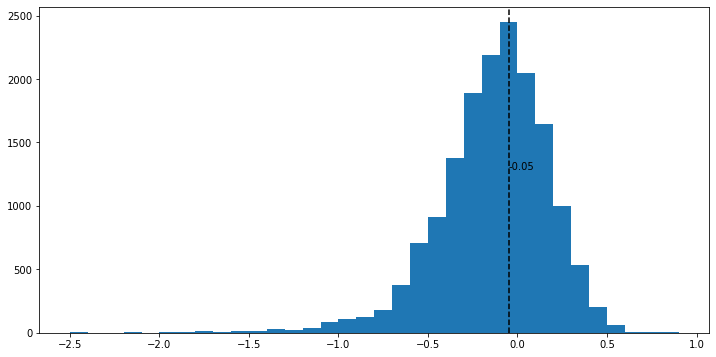

In [3]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
idx = (yu["Phase"]==2)
h = ax.hist(yu["[Fe/H]"], bins=np.arange(-2.5,1.0,0.1))

mean=h[1][np.where(h[0]==h[0].max())[0][0]]+0.05
ax.axvline(mean, linestyle="--", color="black") 
ax.text(mean, np.mean(ax.get_ylim()), "{:0.2f}".format(mean),  color="black")

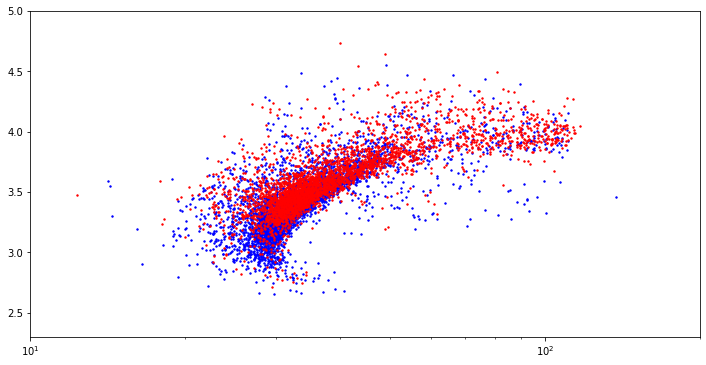

In [16]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.axis([10, 200, 2.3, 5.0])
ax.set_xscale("log")

feh_limits = [-2.0, -0.05, 1.0] 
colors = ["blue", "red"] #sns.diverging_palette(220, 20, n=len(feh_ll))
labels = ["-2.0<[Fe/H]<-0.05", "-0.05<[Fe/H]<1.0"]
for igroup in range(len(feh_limits)-1):
    idx = (yu["[Fe/H]"]>=feh_limits[igroup]) & (yu["[Fe/H]"]<feh_limits[igroup+1]) & (yu["Phase"]==2)
    x, y = yu["numax"][idx], yu["numax"][idx]**0.75/yu["Delnu"][idx]
    ax.scatter(x, y, color=colors[igroup], s=2, label=labels[igroup])


# idx = (yu["[Fe/H]"]>=-1.0) & (yu["[Fe/H]"]<1.0) & (yu["Phase"]==2)
# x, y = yu["numax"][idx], yu["numax"][idx]**0.75/yu["Delnu"][idx]
# c = ax.scatter(x, y, c=yu["[Fe/H]"][idx], s=2, cmap="seismic")
# plt.colorbar(c, ax=ax, orientation='vertical')

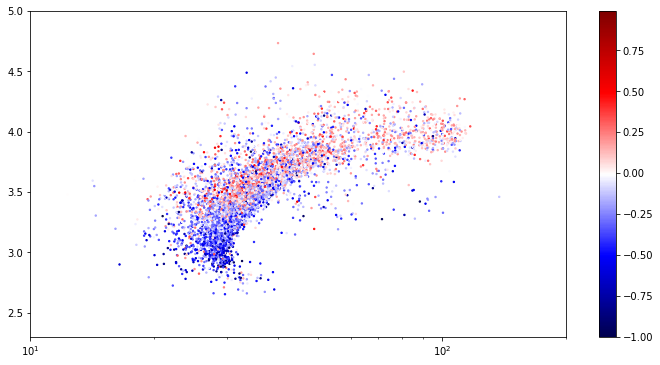

In [17]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.axis([10, 200, 2.3, 5.0])
ax.set_xscale("log")

# idx=(yu["Phase"]==2)
# x, y = yu["numax"][idx], yu["numax"][idx]**0.75/yu["Delnu"][idx]
# feh = yu["[Fe/H]"][idx]
# c=ax.scatter(x, y, c=feh, cmap="rainbow", s=2, label=labels[igroup])
# ax.set_title("Purely observations")
# plt.colorbar(c)
# ax.legend()

idx = (yu["[Fe/H]"]>=-1.0) & (yu["[Fe/H]"]<1.0) & (yu["Phase"]==2)
x, y = yu["numax"][idx], yu["numax"][idx]**0.75/yu["Delnu"][idx]
c = ax.scatter(x, y, c=yu["[Fe/H]"][idx], s=2, cmap="seismic")
plt.colorbar(c, ax=ax, orientation='vertical')

# quantify the dege
## on the two diagrams
### Observations

In [10]:
# set up data
idx = (yu["Phase"]==2) & (np.array(yu["numax"]**0.75/yu["Delnu"])>3.0)
xobs, yobs, yobst = np.array(yu["numax"][idx]), np.array(yu["numax"][idx]**0.75/yu["Delnu"][idx]), np.array(yu["Delnu"][idx])
Nobs = xobs.shape[0]
feh_obs = np.asarray(yu["[Fe/H]"][idx])

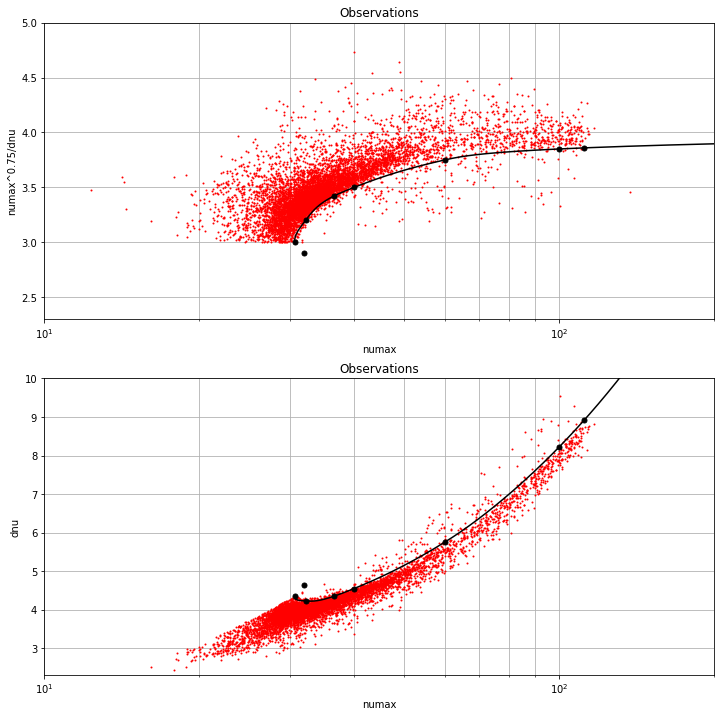

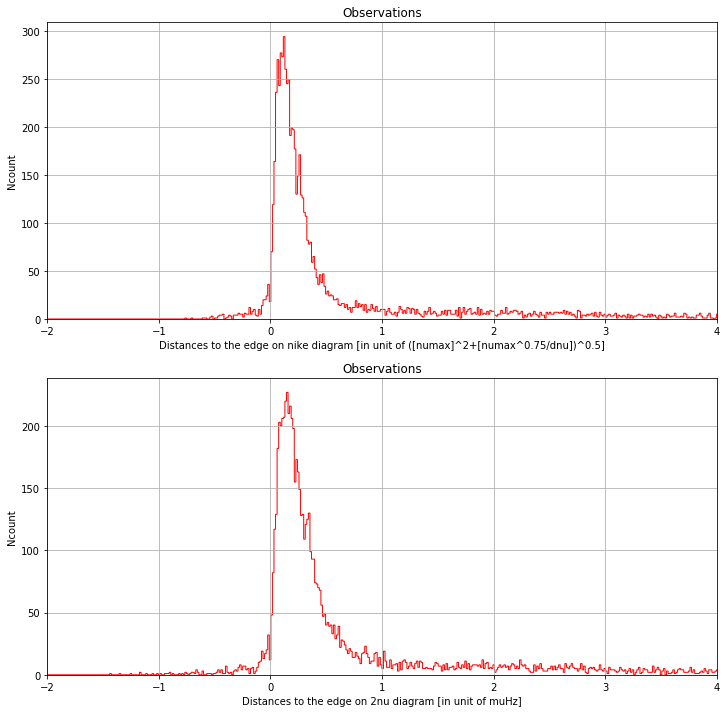

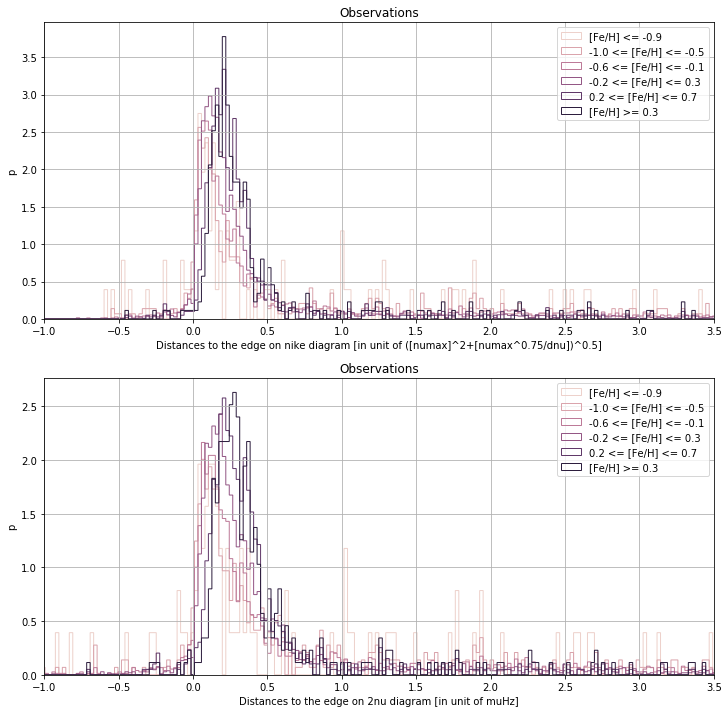

In [22]:
def edge_analysis(xdata, ydata, ydatat, filepath, feh, points, title):
    # plot two diagrams
    fig = plt.figure(figsize=(12,12))
    axes = fig.subplots(nrows=2,ncols=1)
    axes[0].axis([10, 200, 2.3, 5.0])
    axes[0].set_xscale("log")
    axes[1].axis([10, 200, 2.3, 10.0])
    axes[1].set_xscale("log")

    axes[0].plot(xdata, ydata, "r.", markersize=2)
    axes[1].plot(xdata, ydatat, "r.", markersize=2)
    axes[0].set_title(title)
    axes[1].set_title(title)
    axes[0].grid(which="both")
    axes[1].grid(which="both")
    axes[0].set_xlabel("numax")
    axes[1].set_xlabel("numax")
    axes[0].set_ylabel("numax^0.75/dnu")
    axes[1].set_ylabel("dnu")

    # cubic spline interpolation
    # points
    Npoint = len(points)
    xpoint, ypoint = np.array([points[i][0] for i in range(Npoint)]), np.array([points[i][1] for i in range(Npoint)])
    import scipy
    tck = scipy.interpolate.splrep(np.log10(ypoint), np.log10(xpoint), s=0)
    np.save(filepath+"spline_tck", tck)


    # plot knots and edge 
    axes[0].plot(xpoint, ypoint, "k.", markersize=10)
    axes[1].plot(xpoint, xpoint**0.75/ypoint, "k.", markersize=10)
    yedge = np.arange(3.0, 4.0, 0.001)
    xedge = 10.0**scipy.interpolate.splev(np.log10(yedge), tck, der=0)
    Nedge = xedge.shape[0]
    axes[0].plot(xedge, yedge, "k-") 
    axes[1].plot(xedge, xedge**0.75/yedge, "k-") 


    # # shortest distance distribution
    def shortest_distance(xdata, ydata, xedge, yedge):
        Ndata, Nedge = xdata.shape[0], xedge.shape[0]
        X = np.zeros((Ndata+Nedge, 2))
        X[0:Ndata,0], X[0:Ndata,1] = xdata, ydata
        X[Ndata:,0], X[Ndata:,1] = xedge, yedge
        Y = scipy.spatial.distance.pdist(X)
        dist = np.min(scipy.spatial.distance.squareform(Y)[0:Ndata,Ndata:], axis=1)
        return dist

    np.save(filepath+"nike_samples", np.array([xdata, ydata]).T)
    np.save(filepath+"tnu_samples", np.array([xdata, ydatat]).T)

    # left or right?
    idx_right = xdata>10.0**scipy.interpolate.splev(np.log10(ydata), tck, der=0)

    distn = shortest_distance(xdata, ydata, xedge, yedge)
    distn[idx_right] = -distn[idx_right]
    np.save(filepath+"nike_dist", distn)

    distt = shortest_distance(xdata, ydatat, xedge, xedge**0.75/yedge)
    distt[idx_right] = -distt[idx_right]
    np.save(filepath+"tnu_dist", distt)


    # now plot histograms
    fig = plt.figure(figsize=(12,12))
    axes = fig.subplots(nrows=2,ncols=1)
    axes[0].set_xlim(-2, 4)
    axes[1].set_xlim(-2, 4)
    bins0 = np.linspace(-2, 12, 1000)
    bins1 = np.linspace(-2, 12, 1000)
    # bins0 = np.linspace(distn.min(), distn.max(), 1500)
    # bins1 = np.linspace(distt.min(), distt.max(), 1500)
    h=axes[0].hist(distn, histtype="step", color="red",
        bins=bins0, zorder=0)
    h=axes[1].hist(distt, histtype="step", color="red",
        bins=bins1, zorder=0)
    axes[0].set_xlabel("Distances to the edge on nike diagram [in unit of ([numax]^2+[numax^0.75/dnu])^0.5]")
    axes[1].set_xlabel("Distances to the edge on 2nu diagram [in unit of muHz]")
    axes[0].set_ylabel("Ncount")
    axes[1].set_ylabel("Ncount")
    axes[0].grid(which="both")
    axes[1].grid(which="both")
    axes[0].set_title(title)
    axes[1].set_title(title)

    # now plot histograms with metallicity effect
    feh_limits = np.arange(-1.0, 0.5, 0.4)
    binsize = 0.5
    idx_feh = [feh <= feh_limits[0]+binsize-(feh_limits[1]-feh_limits[0])]
    idx_feh_names = ["[Fe/H] <= {:0.1f}".format(feh_limits[0]+binsize-(feh_limits[1]-feh_limits[0]))]
    for feh_start in feh_limits:
        idx_feh.append( (feh>=feh_start) & (feh <= feh_start+binsize) )
        idx_feh_names.append("{:0.1f} <= [Fe/H] <= {:0.1f}".format(feh_start, feh_start+binsize))
    idx_feh.append(feh >= feh_limits[-1]+binsize-(feh_limits[1]-feh_limits[0]) )
    idx_feh_names.append("[Fe/H] >= {:0.1f}".format(feh_limits[-1]+binsize-(feh_limits[1]-feh_limits[0])) )

    fig = plt.figure(figsize=(12,12))
    axes = fig.subplots(nrows=2,ncols=1)
    axes[0].set_xlim(-1, 3.5)
    axes[1].set_xlim(-1, 3.5)
    bins0 = np.linspace(-2, 12, 600)
    bins1 = np.linspace(-2, 12, 600)
    import seaborn as sns 
    colors = sns.cubehelix_palette(len(idx_feh))
    for ifeh in range(len(idx_feh)):
        h=axes[0].hist(distn[idx_feh[ifeh]], histtype="step", color=colors[ifeh], label=idx_feh_names[ifeh], density=True,
            bins=bins0, zorder=0)
        h=axes[1].hist(distt[idx_feh[ifeh]], histtype="step", color=colors[ifeh], label=idx_feh_names[ifeh], density=True,
            bins=bins1, zorder=0)
    axes[0].set_xlabel("Distances to the edge on nike diagram [in unit of ([numax]^2+[numax^0.75/dnu])^0.5]")
    axes[1].set_xlabel("Distances to the edge on 2nu diagram [in unit of muHz]")
    axes[0].set_ylabel("p")
    axes[1].set_ylabel("p")
    axes[0].legend()
    axes[1].legend()
    axes[0].grid(which="both")
    axes[1].grid(which="both")
    axes[0].set_title(title)
    axes[1].set_title(title)
    return


filepath = "sample/obs/"
points=[(32, 2.9), (30.7, 3.0), (32.2, 3.2), (36.5, 3.42), (40, 3.5), (60, 3.75), (100, 3.85), (112, 3.86)]
title = "Observations"
edge_analysis(xobs, yobs, yobst, filepath, feh_obs, points, title)

### Padova

In [23]:
# set up data
import ebf
synp=ebf.read("sample/kepler_galaxia_mrtd5.ebf")
Nstar = synp["alpha"].shape[0]
factor = int(Nstar/16000)
idx = np.arange(0,int(Nstar/factor))*factor
for key in synp.keys():
    synp[key] = synp[key][idx]

idx = (synp["evstate"]==2) & (np.isfinite(synp["numax"])) & (np.array(synp["numax"]**0.75/synp["dnu"])>3.0)
xpdv, ypdv, ypdvt = synp["numax"][idx], synp["numax"][idx]**0.75/synp["dnu"][idx], synp["dnu"][idx]
Npdv = xpdv.shape[0]

feh_pdv = synp["feh"][idx]

C:\Users\yali4742\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


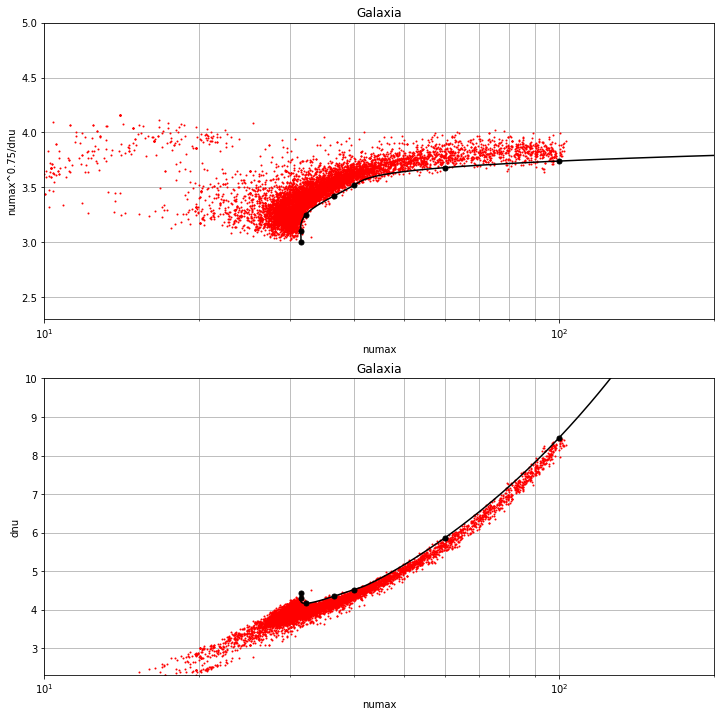

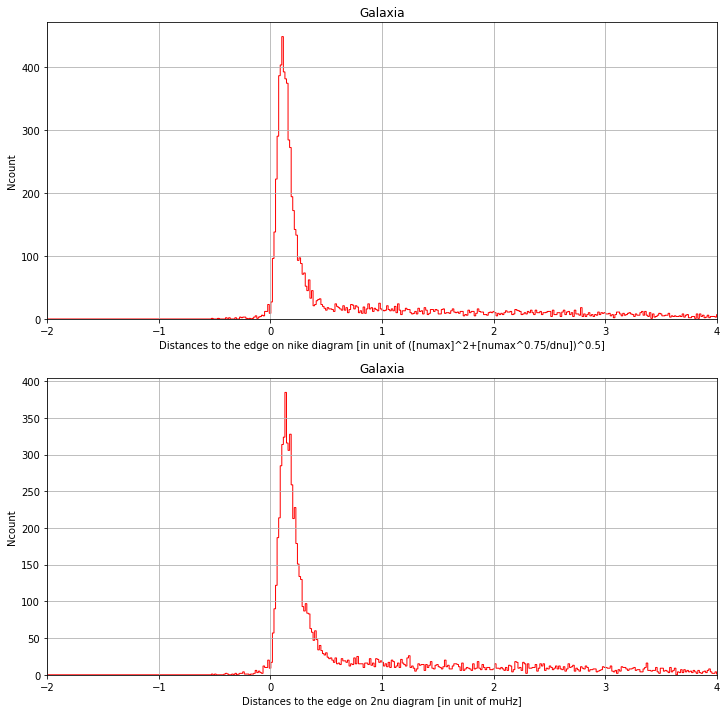

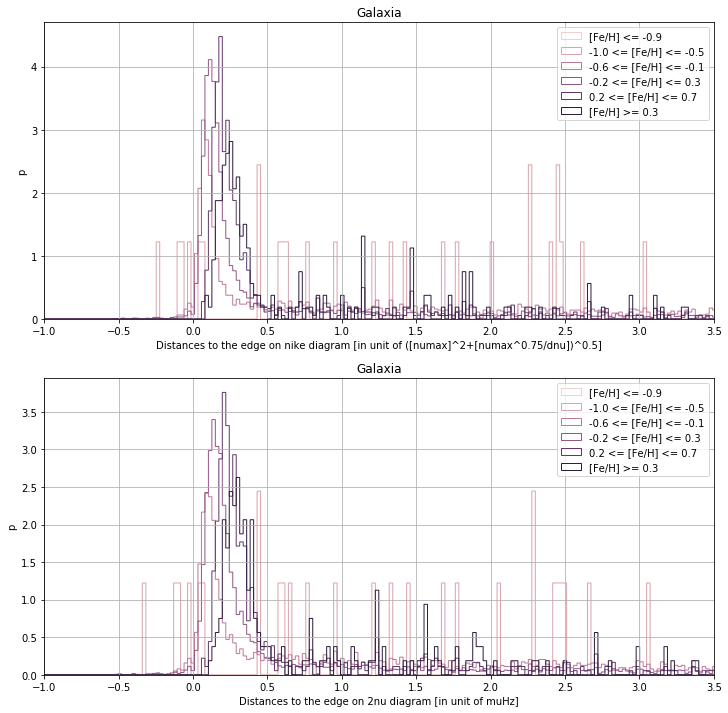

In [24]:
filepath = "sample/padova/"
points=[(31.5, 3.0), (31.5, 3.1), (32.2, 3.25), (36.5, 3.42), (40, 3.52), (60, 3.68), (100, 3.74)]
title = "Galaxia"
edge_analysis(xpdv, ypdv, ypdvt, filepath, feh_pdv, points, title)